In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-equality-curriculum-recommendations/sample_submission.csv
/kaggle/input/learning-equality-curriculum-recommendations/topics.csv
/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv
/kaggle/input/learning-equality-curriculum-recommendations/content.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = '/kaggle/input/learning-equality-curriculum-recommendations/'
content = pd.read_csv(path +'content.csv')
corr = pd.read_csv(path +'correlations.csv')
topics = pd.read_csv(path +'topics.csv')
sub = pd.read_csv(path +'sample_submission.csv')

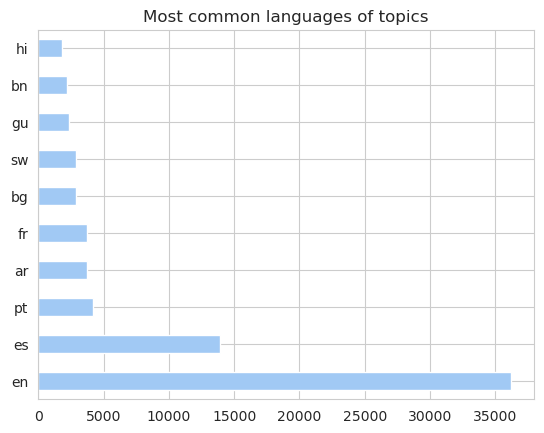

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [4]:
sns.set_style('whitegrid')
sns.set_palette('pastel')
topics.language.value_counts().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Most common languages of topics')
plt.show()
plt.figure(figsize=(8, 6))

From the above graph we can see that english is the most commonly used language in the topics dataframe, followed by spanish.

In [5]:
#Top languages of topics
topics.language.value_counts().sort_values(ascending=False).head(10)


en    36161
es    13910
pt     4177
ar     3701
fr     3701
bg     2867
sw     2860
gu     2320
bn     2176
hi     1786
Name: language, dtype: int64

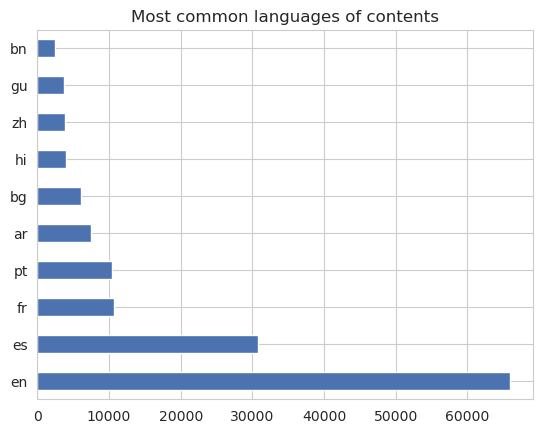

In [6]:
#Top languages of contents
sns.set_style('whitegrid')
sns.set_palette('deep')
content.language.value_counts().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Most common languages of contents')
plt.show()

Same goes for contents, english is the most common followed by spanish.

Important thing to note here is that for both contents and topics, we can use mutlilingual models or focus on only english for our analysis. Furthermore, prediction of content ids can be done only if the language of both the content id and topic id is the same.

In [7]:
content.language.value_counts().sort_values(ascending=False).head(10)

en    65939
es    30844
fr    10682
pt    10435
ar     7418
bg     6050
hi     4042
zh     3849
gu     3677
bn     2513
Name: language, dtype: int64

In [8]:
topics.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


In [9]:
topics.shape

(76972, 9)

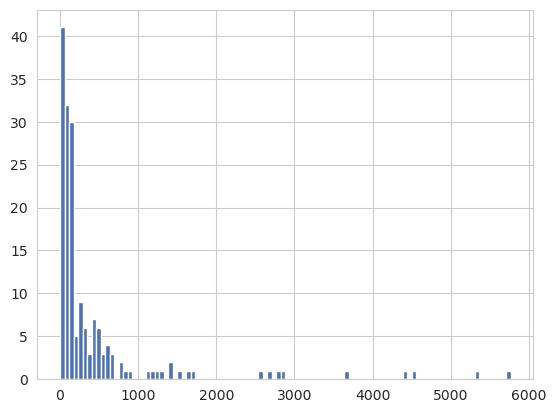

In [10]:
#Sizes of different channels
plt.hist(topics.channel.value_counts(), bins=100)
plt.show()

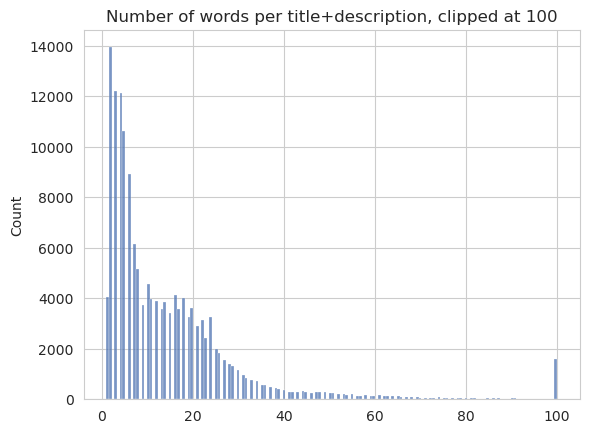

In [11]:
texts = content['title'].fillna('') + ' ' + content['description'].fillna('')
title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 100)

sns.histplot(title_desc_len)
plt.title('Number of words per title+description, clipped at 100')
plt.show()

The number of values less than 100 are quite a few, but the models can handle that. Also in many cases we do not have descriptions and only title is present even for that case we can depend on our model.

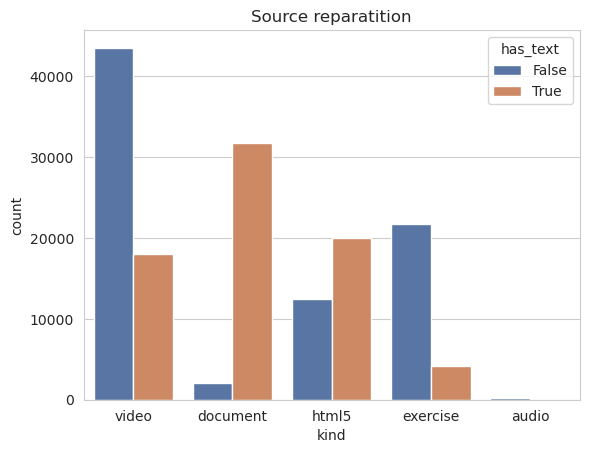

In [12]:
content['has_text'] = ~content['text'].isna()
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.countplot(x="kind", hue="has_text", data=content)
plt.title('Source reparatition')
plt.show()

Most of our text data is from documents, followed by videos.

In [13]:
n_corrs = corr['content_ids'].apply(lambda x: len(x.split(' ')))

print('Total number of correlations :', n_corrs.sum())
print('Average number of correlations per topic :', np.round(n_corrs.mean(), 1))
print('Minimum number of correlations per topic :', n_corrs.min())
print('Maximum number of correlations per topic :', n_corrs.max())

Total number of correlations : 279919
Average number of correlations per topic : 4.6
Minimum number of correlations per topic : 1
Maximum number of correlations per topic : 293


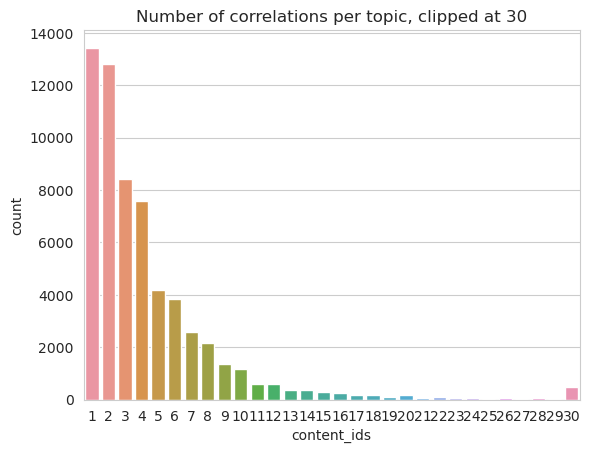

In [14]:
sns.countplot(x=np.clip(n_corrs, 0, 30))
sns.set_style('whitegrid')
sns.set_palette('deep')
plt.title('Number of correlations per topic, clipped at 30')
plt.show()

In [15]:
topics_val = topics[topics['category'] != "source"][["channel", "id"]]
topics_val = topics_val.merge(corr, left_on='id', right_on='topic_id')

channel_val = topics_val.groupby("channel").agg(list).reset_index()
channel_val['content_ids'] = channel_val['content_ids'].apply(lambda x: list(np.unique(np.concatenate([x_.split(' ') for x_ in x]))))

In [16]:
def iou(a, b):
    return len(set(a).intersection(set(b))) / len(set(a + b))

In [17]:
ious = np.zeros((len(channel_val), len(channel_val)))

for i in range(len(channel_val)):
    for j in range(i):
        iou_ij = iou(channel_val['content_ids'][i], channel_val['content_ids'][j])
        ious[i, j] = iou_ij
        ious[j, i] = iou_ij

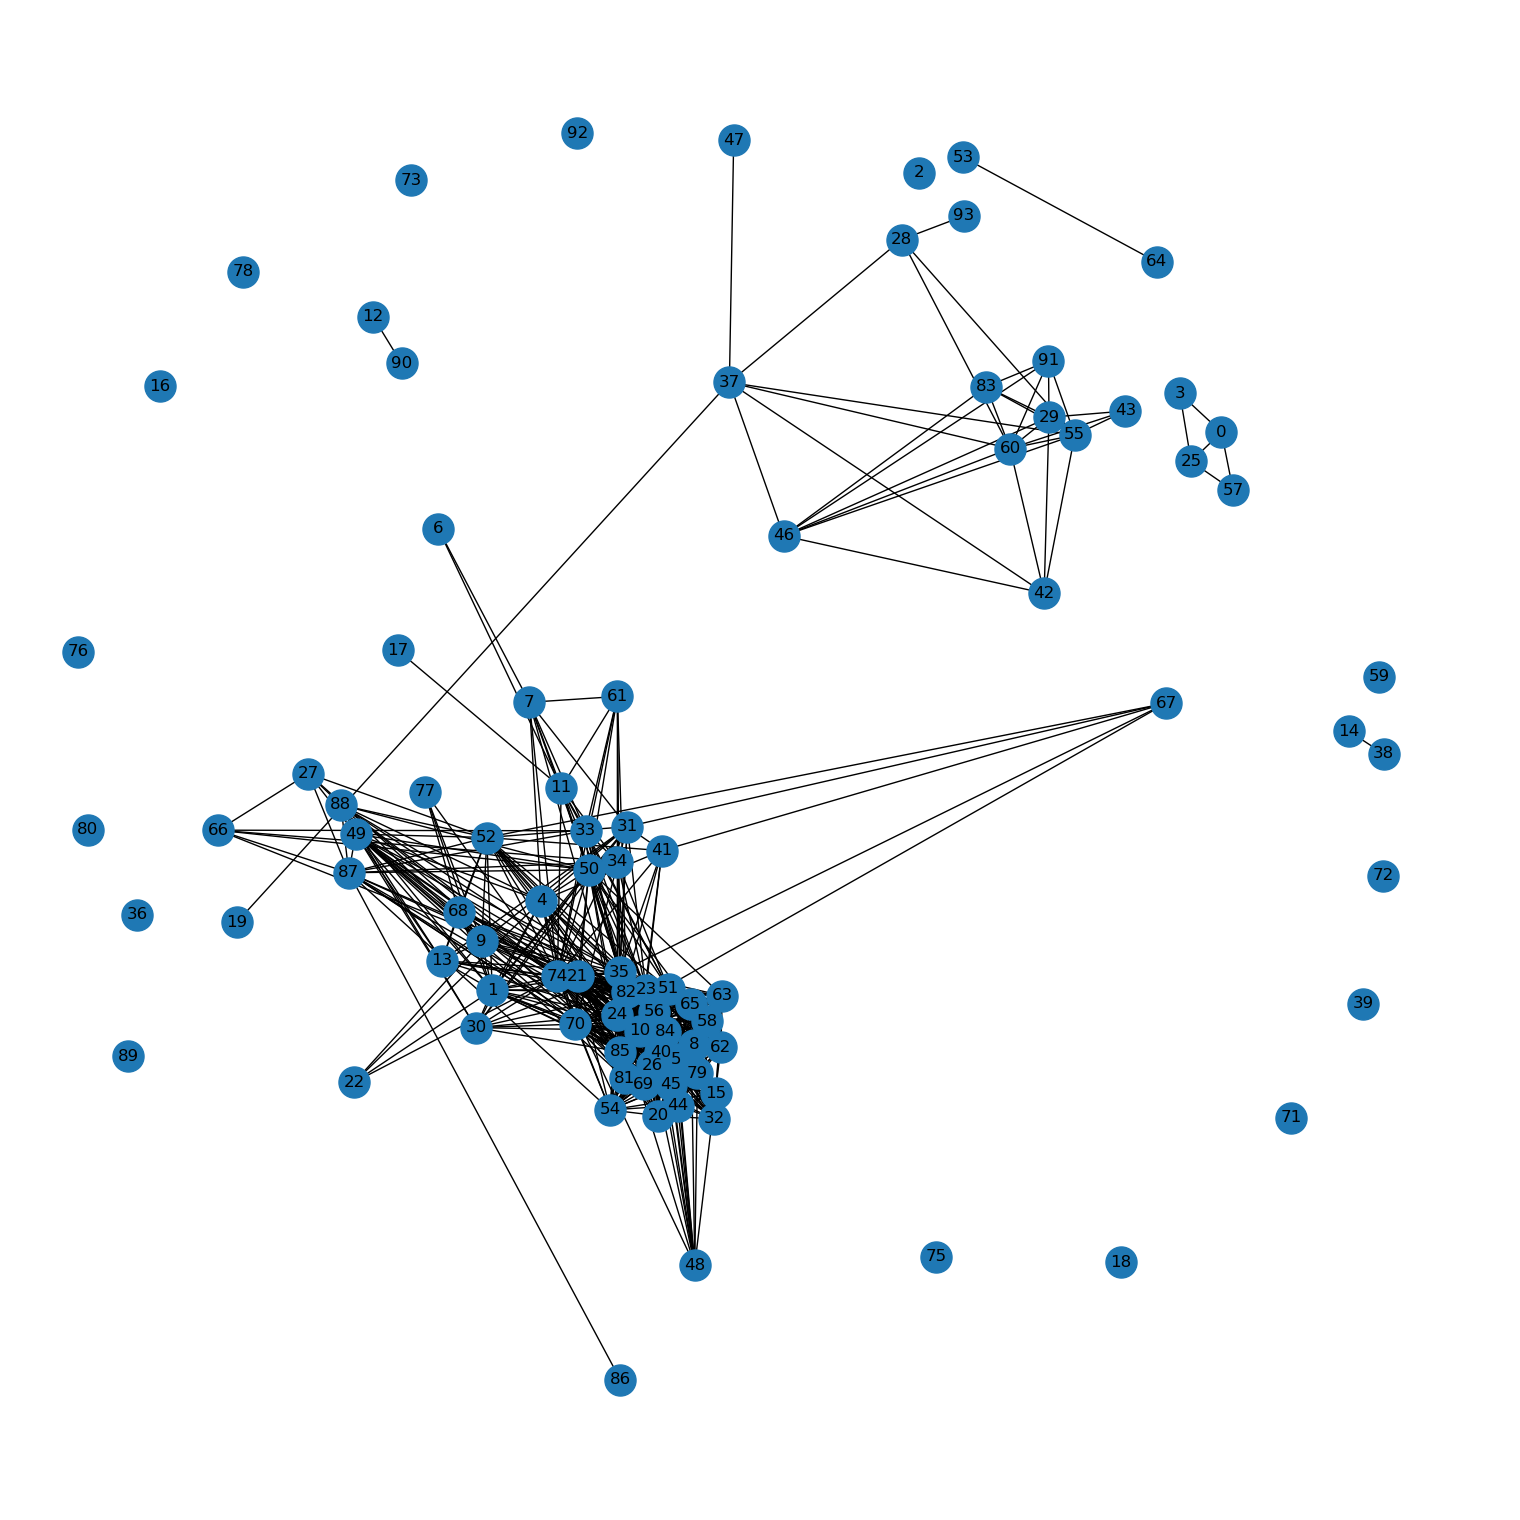

In [18]:
import networkx as nx
G = nx.Graph(ious)  # you can also threshold ious

plt.figure(figsize=(15, 15))
nx.draw(G, node_size=500, with_labels=True)

Network graph between different channels